In [1]:
%pip install tensorflow opencv-python-headless pycocotools numpy pandas matplotlib scipy scikit-learn

Note: you may need to restart the kernel to use updated packages.


In [2]:
import os
import numpy as np
import cv2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from pycocotools.coco import COCO
import tensorflow as tf

image_directory_empty = './parkinglots/notbusy'
image_directory_busy = './parkinglots/busy'
image_directory = './parkinglots'

empty_image_files = [os.path.join(image_directory_empty, f) for f in os.listdir(image_directory_empty) if f.endswith(('.png', '.jpg', '.jpeg'))]
busy_image_files = [os.path.join(image_directory_busy, f) for f in os.listdir(image_directory_busy) if f.endswith(('.png', '.jpg', '.jpeg'))]

image_files = empty_image_files + busy_image_files

labels =[]

# 1 for kinda busy, 0 for kinda empty
for image_file in empty_image_files:
  labels.append(0)
for image_file in busy_image_files:
  labels.append(1)


IMG_SIZE = (128, 128)  # resizing images to 128x128 for consistency (from 640x640)

def load_and_preprocess_image(image_path):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, IMG_SIZE)
    img = img / 255.0  # normalizing pixel values to [0, 1]
    return img


In [ ]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.models import Sequential


def build_model(architecture):
    model = Sequential()
    
    if architecture == 'small':
        model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3)))
        model.add(MaxPooling2D(2, 2))
        model.add(Flatten())
        model.add(Dense(128, activation='relu'))
        model.add(Dropout(0.3))
    
    elif architecture == 'medium':
        model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3)))
        model.add(MaxPooling2D(2, 2))
        model.add(Conv2D(64, (3, 3), activation='relu'))
        model.add(MaxPooling2D(2, 2))
        model.add(Flatten())
        model.add(Dense(256, activation='relu'))
        model.add(Dropout(0.5))
    
    elif architecture == 'large':
        model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3)))
        model.add(MaxPooling2D(2, 2))
        model.add(Conv2D(64, (3, 3), activation='relu'))
        model.add(MaxPooling2D(2, 2))
        model.add(Conv2D(128, (3, 3), activation='relu'))
        model.add(MaxPooling2D(2, 2))
        model.add(Flatten())
        model.add(Dense(512, activation='relu'))
        model.add(Dropout(0.5))
    
    # Common output layer
    model.add(Dense(2, activation='softmax'))  # output layer for "empty" or "occupied" classes
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

architectures = ['small', 'medium', 'large']


In [23]:
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score


file_image = [load_and_preprocess_image(img) for img in image_files]

X_train_val, X_test, y_train_val, y_test = train_test_split(file_image, labels, test_size=0.2, random_state=42)

X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.125, random_state=42)

X_train = np.array(X_train)
y_train = to_categorical(y_train)


X_val = np.array(X_val)
y_val = to_categorical(y_val)

X_test = np.array(X_test)
y_test = to_categorical(y_test)


results = {}
for arch in architectures:
    print(f"Training model with architecture: {arch}")
    model = build_model(arch)
    
    # Early stopping to prevent overfitting
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=20,
        batch_size=32,
        callbacks=[early_stopping],
        verbose=1
    )
    
  
    y_pred = model.predict(X_test)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true = np.argmax(y_test, axis=1)
    
    accuracy = accuracy_score(y_true, y_pred_classes)
    precision = precision_score(y_true, y_pred_classes, average='weighted')
    recall = recall_score(y_true, y_pred_classes, average='weighted')
    f1 = f1_score(y_true, y_pred_classes, average='weighted')
    
    results[arch] = {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1
    }
    
    print(f"Test Accuracy for {arch}: {accuracy:.2f}")
    print(f"Test Precision for {arch}: {precision:.2f}")
    print(f"Test Recall for {arch}: {recall:.2f}")
    print(f"Test F1 Score for {arch}: {f1:.2f}")

# Compare results
print("\nComparison of Model Architectures:")
for arch, metrics in results.items():
    print(f"{arch.capitalize()} - Accuracy: {metrics['accuracy']:.2f}")



Training model with architecture: small


d:\VS CODE\ML_Project\.venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 7s 151ms/step - accuracy: 0.5656 - loss: 5.4412 - val_accuracy: 0.9946 - val_loss: 0.1340
Epoch 2/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 6s 148ms/step - accuracy: 0.9127 - loss: 0.1638 - val_accuracy: 0.9946 - val_loss: 0.0349
Epoch 3/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 6s 149ms/step - accuracy: 0.9784 - loss: 0.0562 - val_accuracy: 1.0000 - val_loss: 0.0053
Epoch 4/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 6s 147ms/step - accuracy: 0.9893 - loss: 0.0599 - val_accuracy: 1.0000 - val_loss: 0.0011
Epoch 5/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 6s 146ms/step - accuracy: 0.9891 - loss: 0.0335 - val_accuracy: 1.0000 - val_loss: 0.0018
Epoch 6/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 6s 144ms/step - accuracy: 0.9981 - loss: 0.0271 - val_accuracy: 1.0000 - val_loss: 0.0012
Epoch 7/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 6s 145ms/step - accuracy: 0.9972 - loss: 0.0364 - val_accuracy: 1.0000 - val_loss: 0.0012
Epoch 8/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 6s 145ms/step - accuracy: 0.9985 - loss: 0.0360 - val_accuracy: 1.

d:\VS CODE\ML_Project\.venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 7s 162ms/step - accuracy: 0.6882 - loss: 1.3454 - val_accuracy: 1.0000 - val_loss: 0.0034
Epoch 2/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 6s 157ms/step - accuracy: 0.9954 - loss: 0.0192 - val_accuracy: 0.9946 - val_loss: 0.0057
Epoch 3/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 7s 158ms/step - accuracy: 0.9971 - loss: 0.0094 - val_accuracy: 1.0000 - val_loss: 0.0028
Epoch 4/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 7s 160ms/step - accuracy: 0.9964 - loss: 0.0120 - val_accuracy: 1.0000 - val_loss: 5.8149e-04
Epoch 5/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 7s 163ms/step - accuracy: 1.0000 - loss: 0.0018 - val_accuracy: 1.0000 - val_loss: 3.2767e-04
Epoch 6/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 7s 159ms/step - accuracy: 0.9949 - loss: 0.0088 - val_accuracy: 1.0000 - val_loss: 0.0013
Epoch 7/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 7s 160ms/step - accuracy: 0.9966 - loss: 0.0091 - val_accuracy: 1.0000 - val_loss: 6.9383e-04
Epoch 8/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 7s 159ms/step - accuracy: 1.0000 - loss: 0.0011 - val_

d:\VS CODE\ML_Project\.venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 8s 171ms/step - accuracy: 0.6919 - loss: 0.6872 - val_accuracy: 0.9946 - val_loss: 0.0193
Epoch 2/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 7s 165ms/step - accuracy: 0.9896 - loss: 0.0390 - val_accuracy: 1.0000 - val_loss: 0.0020
Epoch 3/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 7s 166ms/step - accuracy: 0.9917 - loss: 0.0176 - val_accuracy: 1.0000 - val_loss: 0.0062
Epoch 4/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 7s 168ms/step - accuracy: 0.9891 - loss: 0.0342 - val_accuracy: 1.0000 - val_loss: 6.6064e-04
Epoch 5/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 7s 166ms/step - accuracy: 0.9971 - loss: 0.0101 - val_accuracy: 1.0000 - val_loss: 0.0031
Epoch 6/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 7s 167ms/step - accuracy: 0.9997 - loss: 0.0085 - val_accuracy: 1.0000 - val_loss: 0.0030
Epoch 7/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 7s 166ms/step - accuracy: 0.9907 - loss: 0.0293 - val_accuracy: 1.0000 - val_loss: 0.0028
Epoch 8/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 7s 167ms/step - accuracy: 0.9982 - loss: 0.0079 - val_accuracy

In [24]:
new_image_path = './A.jpg'

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


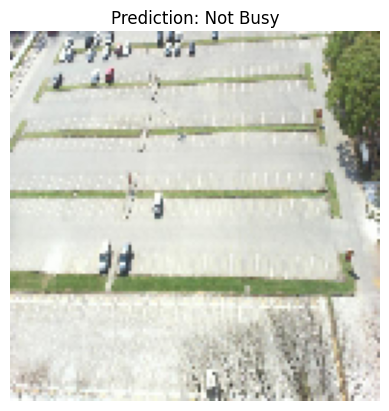

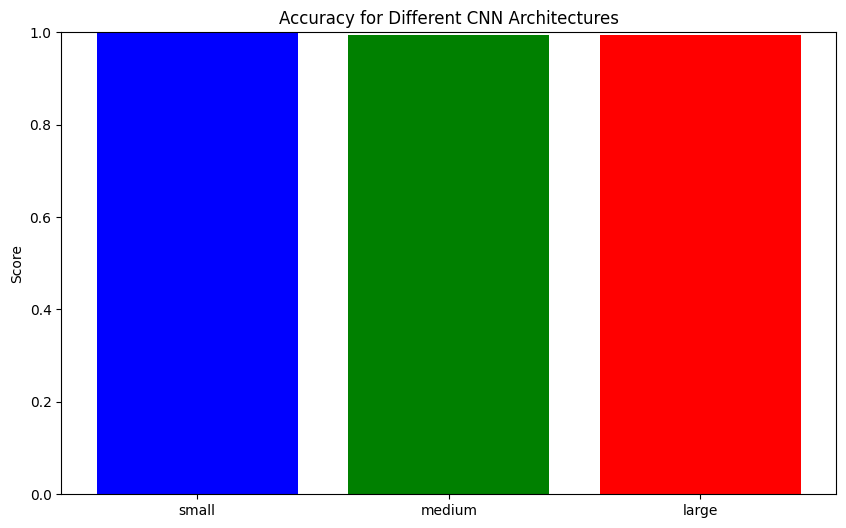

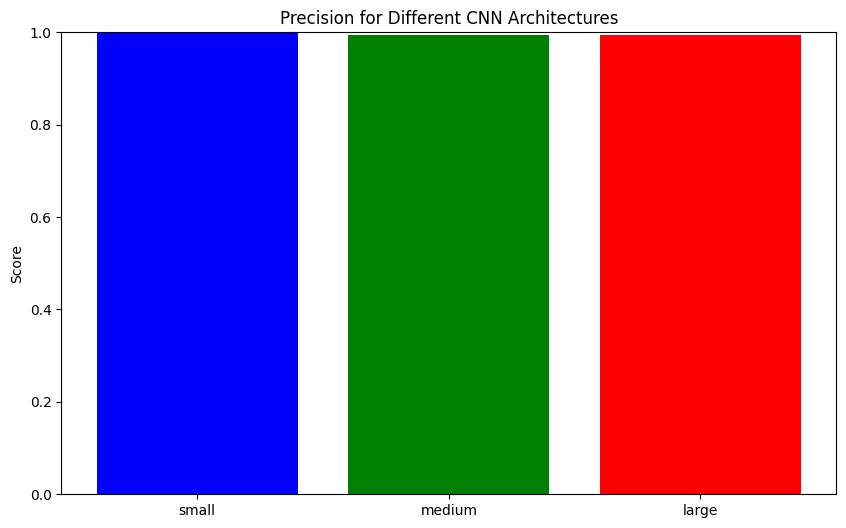

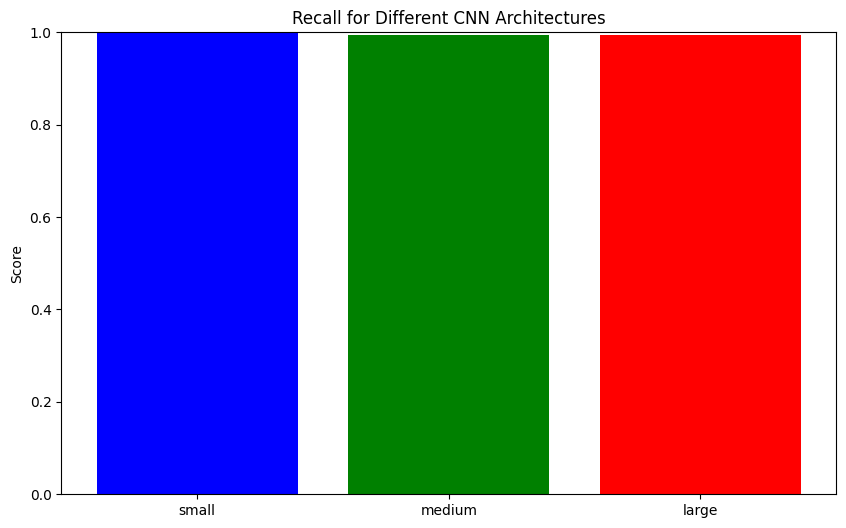

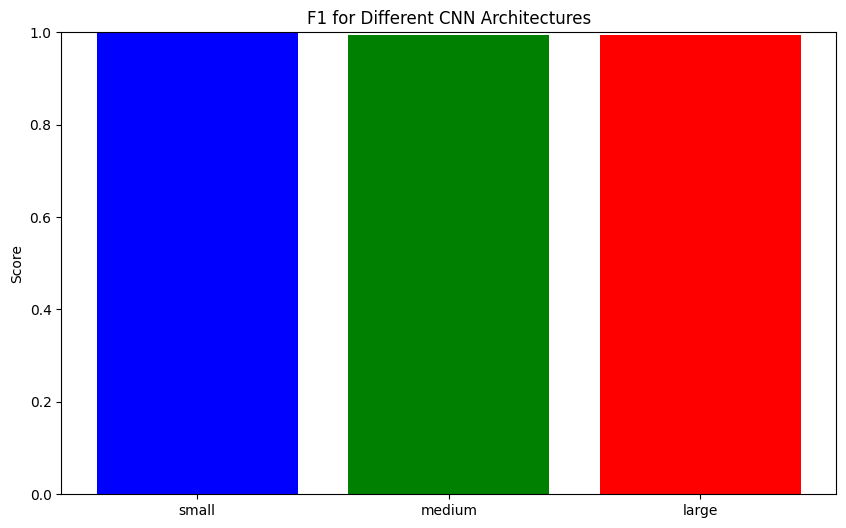

In [25]:
import matplotlib.pyplot as plt
import numpy as np

import matplotlib.pyplot as plt



def visualize_detection(image_path, model):
    img = load_and_preprocess_image(image_path)
    preds = model.predict(np.expand_dims(img, axis=0))
    label = 'Busy' if np.argmax(preds) == 1 else 'Not Busy'
    
    plt.imshow(img)
    plt.title(f'Prediction: {label}')
    plt.axis('off')
    plt.show()

visualize_detection(new_image_path, model)


metrics = ['accuracy', 'precision', 'recall', 'f1']
for metric in metrics:
    values = [results[arch][metric] for arch in architectures]
    plt.figure(figsize=(10, 6))
    plt.bar(architectures, values, color=['blue', 'green', 'red', 'purple'])
    plt.ylim(0, 1)
    plt.ylabel('Score')
    plt.title(f'{metric.capitalize()} for Different CNN Architectures')
    plt.show()



In [26]:
model.save('./cnn_model.keras')